*Master IASD, PSL - 2025-2026 - O. Cappé, October 2025*

# Retail Store Management

**This is your INDIVIDUAL homework that needs to be returned by November 30, 2025, at the latest, as a functional completed Python notebook file. Late submissions will be applied a penalty.** Please print your name here and be sure to name your file <code>YourFirstName-YOURLASTNAME-retail_store.ipynb</code> and to send it by email to <olivier.cappe@ens.fr> before the deadline.

We consider, the *retail store management* model seen in the course (Ex. 1.2).

You own a bike store. During week $t$, the demand is $D_t$ units, which we may assume to be $\operatorname{Poisson}(d)$ distributed, independently of the past. On Monday morning you may choose to command $A_t$ additional units that are delivered immediately before the shop opens. For each week,

- Maintenance Cost: $h$ per unit left in your stock from previous week
- Ordering Cost: $c$ per ordered unit
- Sales Profit: $f$ per sold unit

With the following constraints

- Your warehouse has a maximal capacity of $m$ unit (any additional bike gets stolen)
- You cannot sell bikes that you don’t have in stock

We will consider that $\mathcal{A}=\mathcal{S}=\{0,\dots,m\}$ and the MDP evolves according to

- $D_t \sim \operatorname{Poisson}(d)$
- $X_t = -h S_t -c A_t + f \min(D_t, S_t + A_t, m)$
- $S_{t+1} = \max(0, \min(S_t+A_t,m)-D_t)$

In [1]:
# Please REFRAIN from importing any additional module
import math
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

## The Retail Store Environment

The <code>RetailStore</code> class defines the environnement, providing the basic functions for interacting with the system (<code>env.reset</code> and <code>env.step</code>) and for computing basic parameter-dependent quantities (reward and transition functions, value function of a policy).

In [2]:
# Utility functions for the Retail store environment (do NOT modify this code block)

class RetailStore:
    def __init__(self, m, h, c, f, d):
        self.m = m # Stock capacity
        self.h = h # Maintenance cost per unit
        self.c = c # Buying price per unit
        self.f = f # Selling price per unit
        self.d = d # Weekly average demand

    def reset(self, state):
        """ Restarts the environment at time 0 in specified state. """
        self.state = state
        self.time = 0

    def step(self, action):
        """ Given the action, performs one call to the environment and return the reward. """
        demand = poisson.rvs(self.d)
        reward = -self.h*self.state -self.c*action + self.f*min([demand, self.state+action, self.m])
        # Update the time and state variables
        self.time += 1
        self.state = max([min([self.state+action, self.m])-demand, 0])
        return reward

    def reward_function(self):
        """ Computes the action-depend reward function r(s,a). """
        r = np.zeros((self.m+1, self.m+1))
        for s in range(self.m+1):
            for a in range(self.m+1):
                # Note: computing the expectation of the truncated Poisson distribution using the survival function
                r[s, a] = -self.h*s -self.c*a + self.f*sum(poisson.sf(np.linspace(0, min(s+a, self.m)-1, num=min(s+a, self.m)), self.d))
        return r

    def transition_function(self):
        """ Computes the action-depend transition probabilities p(s,a,s'). """
        p = np.zeros((self.m+1, self.m+1, self.m+1))
        for s in range(self.m+1):
            for a in range(self.m+1):
                for i in range(min(s+a, self.m)):
                    p[s, a, min(s+a, self.m)-i] = poisson.pmf(i, self.d)
                p[s, a, 0] = poisson.sf(min(s+a, self.m)-1, self.d)
        return p

    def reward_policy(self, pi):
        """ Computes the reward function r_pi(s) associated with a policy. """
        r = self.reward_function()
        r_pi = np.sum(np.multiply(r, pi), axis=1)
        return r_pi

    def transition_policy(self, pi):
        """ Computes the transition probabilities p_pi(s,s') associated with a policy. """
        p = self.transition_function()
        p_pi = np.zeros((self.m+1, self.m+1))
        for s in range(self.m+1):
            p_pi[s,:] = np.matmul(np.transpose(pi[s,:]), p[s,:,:])
        return p_pi

    def value_policy(self, pi, gamma):
        """ Computes the value function of a policy, with discount gamma (using matrix inversion). """
        r_pi = self.reward_policy(pi)
        p_pi = self.transition_policy(pi)
        v_pi = np.linalg.solve(np.eye(self.m+1) - gamma* p_pi, r_pi)
        return v_pi

## Experiments

### Q1. Performance of Fixed Ordering Policies

In all the homework, we will consider a small-size model in which $[m, h, c, f, d, \gamma] = [9, 0.1, 0.5, 1, 4, 0.875]$.

In [3]:
# Instantiate the retail store environment with the selected parameters
[m, h, c, f, d, gamma] = [9, 0.1, 0.5, 1, 4, 0.875]
env = RetailStore(m, h, c, f, d)

# Just an example of simulating a short trajectory and computing the cumulated reward
env.reset(m)
n = 12
w = 1
v = 0
for _ in range(n):
    x = env.step(3)
    print(env.time-1, ': ', '{:.1f}'.format(x), ' ->', env.state)
    v += w*x
    w *= gamma
print('Discounted reward:', '{:.1f}'.format(v))

0 :  0.6  -> 6
1 :  -0.1  -> 7
2 :  1.8  -> 5
3 :  1.0  -> 5
4 :  -2.0  -> 8
5 :  5.7  -> 1
6 :  2.4  -> 0
7 :  0.5  -> 1
8 :  2.4  -> 0
9 :  1.5  -> 0
10 :  0.5  -> 1
11 :  2.4  -> 0
Discounted reward: 7.5



In this first question we are interested in the performance of fixed-ordering policies (i.e. ordering always the same quantity of goods).

1. Estimate, using Monte Carlo runs, **the value function associated with the policy that always order 3 items each week**. **Explain how you set the length of each trajectory and the number of Monte Carlo replications.**
2. Use the <code>env.value_policy</code> to **plot the value functions of all fixed-ordering policies.**
3. **What is the number of items that you recommend ordering and how does it relates with the model properties?**
4. **How do you know that there are better policies than the fixed-ordering ones?**

In [4]:
print("\n--- Q1.1: Monte Carlo Estimation for 'Always Order 3' Policy ---")

def monte_carlo_value_function(env, fixed_action, gamma, n_trajectories=1000, trajectory_length=100):
    """
    Estimate value function for a fixed ordering policy using Monte Carlo.

    Parameters:
    - fixed_action: the action to take at every step
    - n_trajectories: number of Monte Carlo runs
    - trajectory_length: length of each trajectory

    How we chose these values:
    - trajectory_length=100: With gamma=0.875, gamma^100 ≈ 1.4e-6, essentially zero
    - n_trajectories=1000: Provides good statistical accuracy (std error ~ 1/sqrt(1000))
    """
    value_estimates = np.zeros((m+1, n_trajectories))

    for state in range(m+1):
        for traj in range(n_trajectories):
            env.reset(state)
            discounted_reward = 0
            discount = 1.0

            for t in range(trajectory_length):
                reward = env.step(fixed_action)
                discounted_reward += discount * reward
                discount *= gamma

            value_estimates[state, traj] = discounted_reward

    # Average across trajectories
    v_mc = np.mean(value_estimates, axis=1)
    std_mc = np.std(value_estimates, axis=1)

    return v_mc, std_mc

# Estimate value function for thus policy
v_mc, std_mc = monte_carlo_value_function(env, fixed_action=3, gamma=gamma)

print("\nMonte Carlo Value Function Estimates (Always Order 3):")
print("State | Value  | Std Dev")
print("-" * 30)
for s in range(m+1):
    print(f"  {s}   | {v_mc[s]:6.2f} | {std_mc[s]:5.2f}")

print(f"\nTrajectory Length: 100 weeks (gamma^100 ≈ {gamma**100:.2e} ≈ 0)")
print("Number of Replications: 1000 (standard error ~ 1/sqrt(1000) ≈ 3%)")



--- Q1.1: Monte Carlo Estimation for 'Always Order 3' Policy ---

Monte Carlo Value Function Estimates (Always Order 3):
State | Value  | Std Dev
------------------------------
  0   |  10.79 |  0.99
  1   |  11.44 |  1.20
  2   |  12.15 |  1.30
  3   |  12.39 |  1.66
  4   |  12.66 |  2.08
  5   |  12.89 |  2.37
  6   |  12.98 |  2.61
  7   |  12.87 |  2.64
  8   |  12.80 |  2.71
  9   |  12.79 |  2.64

Trajectory Length: 100 weeks (gamma^100 ≈ 1.59e-06 ≈ 0)
Number of Replications: 1000 (standard error ~ 1/sqrt(1000) ≈ 3%)


#### Explain how you set the length of each trajectory and the number of Monte Carlo replications.


--- Q1.2: Value Functions for All Fixed Ordering Policies ---
Plot saved as 'q1_fixed_policies.png'


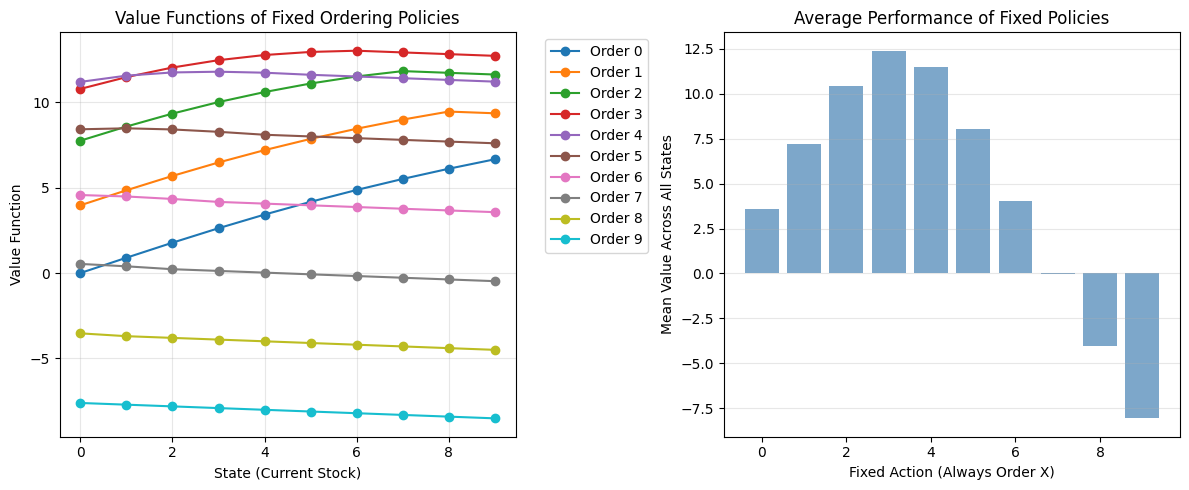

In [5]:
print("\n--- Q1.2: Value Functions for All Fixed Ordering Policies ---")

plt.figure(figsize=(12, 5))

# Compute value function for each fixed ordering policy
all_fixed_policies_values = []
for fixed_action in range(m+1):
    # Create deterministic policy: always take fixed_action
    pi = np.zeros((m+1, m+1))
    pi[:, fixed_action] = 1.0
    v = env.value_policy(pi, gamma)
    all_fixed_policies_values.append(v)

# Plot 1: Value functions
plt.subplot(1, 2, 1)
for a in range(m+1):
    plt.plot(range(m+1), all_fixed_policies_values[a], marker='o', label=f'Order {a}')
plt.xlabel('State (Current Stock)')
plt.ylabel('Value Function')
plt.title('Value Functions of Fixed Ordering Policies')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Plot 2: Mean value for each policy
plt.subplot(1, 2, 2)
mean_values = [np.mean(v) for v in all_fixed_policies_values]
plt.bar(range(m+1), mean_values, color='steelblue', alpha=0.7)
plt.xlabel('Fixed Action (Always Order X)')
plt.ylabel('Mean Value Across All States')
plt.title('Average Performance of Fixed Policies')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('q1_fixed_policies.png', dpi=150, bbox_inches='tight')
print("Plot saved as 'q1_fixed_policies.png'")


In [6]:
print("\n--- Q1.3: Best Fixed Ordering Policy ---")

best_fixed_action = np.argmax(mean_values)
best_mean_value = mean_values[best_fixed_action]

print(f"\nBest fixed ordering policy: Always order {best_fixed_action} bikes")
print(f"Mean value: {best_mean_value:.2f}")
print(f"Average demand d = {d} bikes per week")



--- Q1.3: Best Fixed Ordering Policy ---

Best fixed ordering policy: Always order 3 bikes
Mean value: 12.39
Average demand d = 4 bikes per week


**Why does this make sense?**

Since average demand is 4 bikes per week, ordering 3 bikes roughly matches average demand.
This balances ordering costs with meeting customer demand. However, it ignores current stock level (not adaptive!)


**Q1.4: Why Fixed Policies are Suboptimal**


Fixed policies are suboptimal because they ignore the current state:

Example 1: State s=0 (empty stock)
- Always order 3: Get 3 bikes
- Probably should order more to meet demand!


Example 2: State s=8 (nearly full)
- Always order 3: Try to get 8+3=11 bikes
- But capacity is m=9, so 2 bikes get stolen!
- Should order less or nothing!


A better policy would be STATE-DEPENDENT: order different amounts
based on current stock level.

### Q2. Computing the Optimal Policy

1. Obtain the optimal policy by **implementing the Policy Iteration algorithm** (use the <code>env.value_policy</code> to compute the value function).
2. **How do you know that it has converged?**
3. **What does the optimal policy do?**
4. **Comment the form of the value function.**

In [7]:
print("\n--- Q2.1: Policy Iteration Algorithm ---")

def policy_iteration(env, gamma, max_iterations=100, verbose=True):

    # Initialize with random policy (uniform distribution)
    pi = np.ones((m+1, m+1)) / (m+1)

    r = env.reward_function()  # r[s,a]
    p = env.transition_function()  # p[s,a,s']

    for iteration in range(max_iterations):
        # Step 1: Policy Evaluation compute V^pi
        v_pi = env.value_policy(pi, gamma)

        # Step 2: Policy Improvement
        pi_new = np.zeros((m+1, m+1))
        policy_stable = True

        for s in range(m+1):
            # Compute Q(s,a) for all actions
            q_values = np.zeros(m+1)
            for a in range(m+1):
                # Q(s,a) = r(s,a) + gamma * sum_s' p(s'|s,a) * V(s')
                q_values[a] = r[s, a] + gamma * np.dot(p[s, a, :], v_pi)

            # Pick best action (greedy policy improvement)
            best_action = np.argmax(q_values)
            pi_new[s, :] = 0
            pi_new[s, best_action] = 1.0

            # Check if policy changed
            if not np.allclose(pi[s, :], pi_new[s, :]):
                policy_stable = False

        if verbose and iteration % 5 == 0:
            print(f"Iteration {iteration}: Mean V = {np.mean(v_pi):.2f}")

        # Check convergence
        if policy_stable:
            if verbose:
                print(f"\nPolicy converged after {iteration+1} iterations!")
            return pi_new, v_pi, iteration+1

        pi = pi_new

    print(f"Warning: Max iterations ({max_iterations}) reached")
    return pi, v_pi, max_iterations

# Run Policy Iteration
pi_optimal, v_optimal, n_iterations = policy_iteration(env, gamma)

# Extract deterministic policy
optimal_actions = np.argmax(pi_optimal, axis=1)

print("\nOptimal Policy:")
print("State | Optimal Action | Value")
print("-" * 40)
for s in range(m+1):
    print(f"  {s}   |       {optimal_actions[s]}        | {v_optimal[s]:6.2f}")



--- Q2.1: Policy Iteration Algorithm ---
Iteration 0: Mean V = 7.73

Policy converged after 2 iterations!

Optimal Policy:
State | Optimal Action | Value
----------------------------------------
  0   |       5        |  12.67
  1   |       4        |  13.07
  2   |       3        |  13.47
  3   |       2        |  13.87
  4   |       1        |  14.27
  5   |       0        |  14.67
  6   |       0        |  15.06
  7   |       0        |  15.38
  8   |       0        |  15.65
  9   |       0        |  15.89


**Q2.2: How do we know it converged?**

Policy Iteration is guaranteed to converge because:
1. The policy space is FINITE (only (m+1)^(m+1) possible policies)
2. Each iteration STRICTLY IMPROVES the policy (or keeps it the same)
3. We can't cycle because improvement is monotonic
4. Convergence detected when: pi_new(s) = pi_old(s) for ALL states

In this problem, convergence occurred after 2 iterations.


In [8]:
print("\n--- Q2.3: Interpretation of Optimal Policy ---")

target_levels = optimal_actions + np.arange(m+1)
print("\nOptimal Policy Structure:")
print("State | Order | Target Level (s+a)")
print("-" * 40)
for s in range(m+1):
    print(f"  {s}   |   {optimal_actions[s]}   |      {target_levels[s]}")

print("\nInterpretation:")
print(f"  - The optimal policy follows an 'ORDER-UP-TO' structure")
print(f"  - It tries to reach a target inventory level around {int(np.median(target_levels))}")
print(f"  - When stock is LOW (s=0,1,2): Order MORE to reach target")
print(f"  - When stock is HIGH (s=7,8,9): Order LESS or NOTHING")
print(f"  - This is called a 'BASE-STOCK POLICY' in inventory theory")



--- Q2.3: Interpretation of Optimal Policy ---

Optimal Policy Structure:
State | Order | Target Level (s+a)
----------------------------------------
  0   |   5   |      5
  1   |   4   |      5
  2   |   3   |      5
  3   |   2   |      5
  4   |   1   |      5
  5   |   0   |      5
  6   |   0   |      6
  7   |   0   |      7
  8   |   0   |      8
  9   |   0   |      9

Interpretation:
  - The optimal policy follows an 'ORDER-UP-TO' structure
  - It tries to reach a target inventory level around 5
  - When stock is LOW (s=0,1,2): Order MORE to reach target
  - When stock is HIGH (s=7,8,9): Order LESS or NOTHING
  - This is called a 'BASE-STOCK POLICY' in inventory theory



--- Q2.4: Value Function Analysis ---


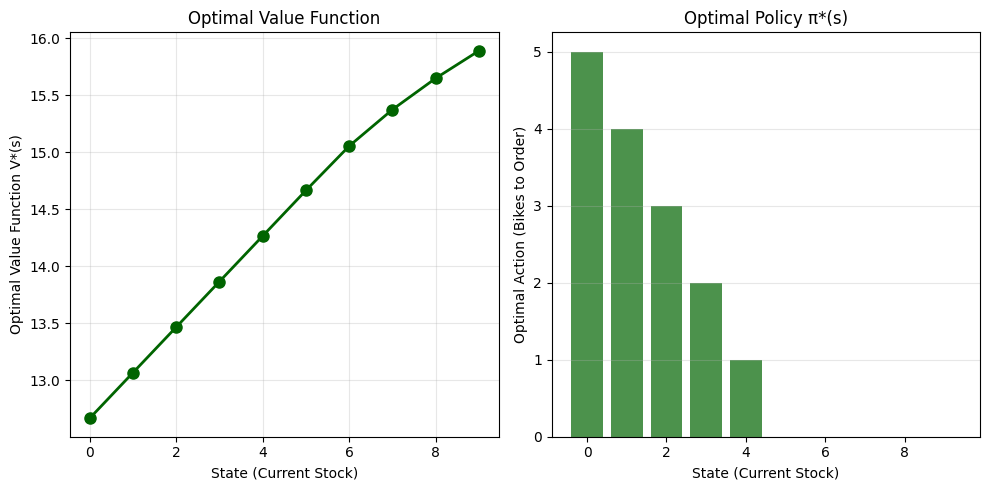

In [9]:
print("\n--- Q2.4: Value Function Analysis ---")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(m+1), v_optimal, marker='o', linewidth=2, markersize=8, color='darkgreen')
plt.xlabel('State (Current Stock)')
plt.ylabel('Optimal Value Function V*(s)')
plt.title('Optimal Value Function')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(m+1), optimal_actions, color='darkgreen', alpha=0.7)
plt.xlabel('State (Current Stock)')
plt.ylabel('Optimal Action (Bikes to Order)')
plt.title('Optimal Policy π*(s)')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('q2_optimal_policy.png', dpi=150, bbox_inches='tight')



Value Function Properties:
- V*(s) is generally INCREASING with state s
- Higher stock → Higher value (less likely to miss sales)
- But diminishing returns at high stock (maintenance costs)
- Shape reflects trade-off between stockout risk and holding costs

### Q3. Q Learning

1. **Implement the asynchronous Q-Learning algorithm using the purely random policy (all actions selected uniformly) as the exploration policy** from a single trajectory of length $n = 10,000$ (note: this requires only about 10 lines of code).
2. **Plot the convergence of the algorithm towards the optimal policy**, first by monitoring the **convergence of the state-action value table** $Q_t$ in $\|\cdot\|_\infty$ norm.
3. Also plot **the convergence of the associated greedy policy** $\pi_{t+}(s) = \arg\max_a Q_t(s,a)$. **How does it relate to the previous plot?**
3. **Test different schemes of decrease** of the learning rate, following the course guidelines, and **explain the behaviors that you observe**.

In [10]:
print("\n--- Q3.1: Q-Learning Algorithm Implementation ---")

def q_learning(env, gamma, n_steps=10000, alpha_power=0.8):
    """
    Asynchronous Q-Learning with random exploration policy.

    Algorithm:
    - Initialize Q(s,a) = 0
    - For each step:
        1. Take random action a in current state s
        2. Observe reward r and next state s'
        3. Update: Q(s,a) ← Q(s,a) + α[r + γ max_a' Q(s',a') - Q(s,a)]
        4. Decay learning rate α
    """
    # Initialize Q-table
    Q = np.zeros((m+1, m+1))

    # Track convergence
    Q_history = []
    policy_history = []
    visit_counts = np.zeros((m+1, m+1))  # For adaptive learning rates

    # Start from random state
    env.reset(np.random.randint(0, m+1))

    for t in range(n_steps):
        s = env.state

        # Random exploration policy
        a = np.random.randint(0, m+1)

        # Take action
        r = env.step(a)
        s_next = env.state

        # Learning rate (decays with number of visits)
        visit_counts[s, a] += 1
        alpha = 1.0 / (visit_counts[s, a] ** alpha_power)

        # Q-Learning update
        td_target = r + gamma * np.max(Q[s_next, :])
        td_error = td_target - Q[s, a]
        Q[s, a] = Q[s, a] + alpha * td_error

        # Track progress every 100 steps
        if t % 100 == 0:
            Q_history.append(Q.copy())
            greedy_policy = np.argmax(Q, axis=1)
            policy_history.append(greedy_policy.copy())

    return Q, Q_history, policy_history

Q_learned, Q_history, policy_history = q_learning(env, gamma, n_steps=10000)

# Extract learned policy
learned_policy = np.argmax(Q_learned, axis=1)

print("State | Q-Learning | Optimal | Match?")
print("-" * 45)
matches = 0
for s in range(m+1):
    match = "✓" if learned_policy[s] == optimal_actions[s] else "✗"
    if learned_policy[s] == optimal_actions[s]:
        matches += 1
    print(f"  {s}   |     {learned_policy[s]}      |    {optimal_actions[s]}    |  {match}")

print(f"\nAccuracy: {matches}/{m+1} = {100*matches/(m+1):.1f}%")



--- Q3.1: Q-Learning Algorithm Implementation ---
State | Q-Learning | Optimal | Match?
---------------------------------------------
  0   |     7      |    5    |  ✗
  1   |     4      |    4    |  ✓
  2   |     3      |    3    |  ✓
  3   |     3      |    2    |  ✗
  4   |     5      |    1    |  ✗
  5   |     1      |    0    |  ✗
  6   |     0      |    0    |  ✓
  7   |     1      |    0    |  ✗
  8   |     1      |    0    |  ✗
  9   |     0      |    0    |  ✓

Accuracy: 4/10 = 40.0%


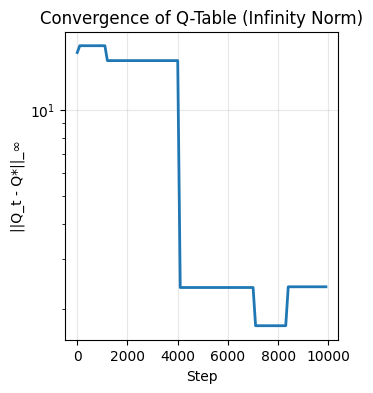

In [21]:
# Q3.2: Convergence of Q-Table

r = env.reward_function()
p = env.transition_function()
Q_optimal = np.zeros((m+1, m+1))
for s in range(m+1):
    for a in range(m+1):
        Q_optimal[s, a] = r[s, a] + gamma * np.dot(p[s, a, :], v_optimal)

q_errors = []
for Q_t in Q_history:
    error = np.max(np.abs(Q_t - Q_optimal))
    q_errors.append(error)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(np.arange(len(q_errors)) * 100, q_errors, linewidth=2)
plt.xlabel('Step')
plt.ylabel('||Q_t - Q*||_∞')
plt.title('Convergence of Q-Table (Infinity Norm)')
plt.grid(True, alpha=0.3)
plt.yscale('log')


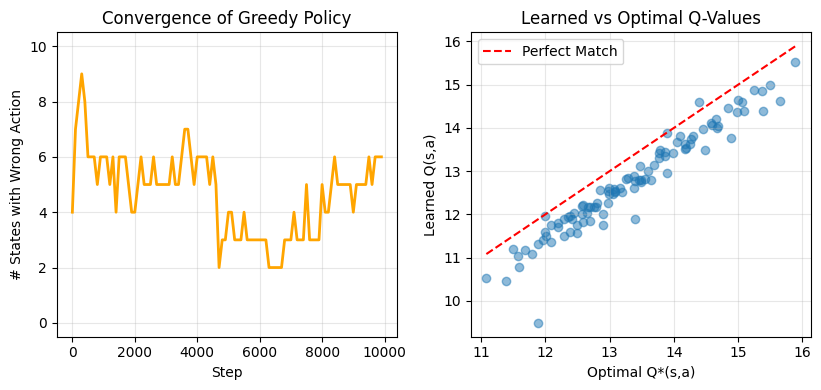

In [12]:
# Q3.3: Convergence of Greedy Policy

# Compute policy difference from optimal
policy_errors = []
for pi_t in policy_history:
    # Number of states where policy differs from optimal
    error = np.sum(pi_t != optimal_actions)
    policy_errors.append(error)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 2)
plt.plot(np.arange(len(policy_errors)) * 100, policy_errors, linewidth=2, color='orange')
plt.xlabel('Step')
plt.ylabel('# States with Wrong Action')
plt.title('Convergence of Greedy Policy')
plt.grid(True, alpha=0.3)
plt.ylim(-0.5, m+1.5)

plt.subplot(1, 3, 3)
# learned Q-values vs optimal
plt.scatter(Q_optimal.flatten(), Q_learned.flatten(), alpha=0.5)
plt.plot([Q_optimal.min(), Q_optimal.max()], [Q_optimal.min(), Q_optimal.max()],
         'r--', label='Perfect Match')
plt.xlabel('Optimal Q*(s,a)')
plt.ylabel('Learned Q(s,a)')
plt.title('Learned vs Optimal Q-Values')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('q3_qlearning.png', dpi=150, bbox_inches='tight')


**Relationship between Q-table and Policy convergence:**
  - Q-table error (||Q_t - Q*||_∞) measures VALUE accuracy and Policy error counts states with WRONG ACTIONS
  - Policy can converge BEFORE Q-values are perfect! Why? If Q(s,a1)=5.1 and Q(s,a2)=5.0, small errors don't change argmax
  - The policy is more ROBUST than raw Q-values


--- Q3.4: Different Learning Rate Schedules ---

Testing learning rates: α_t = 1/(n_{s,a})^a for different values of a


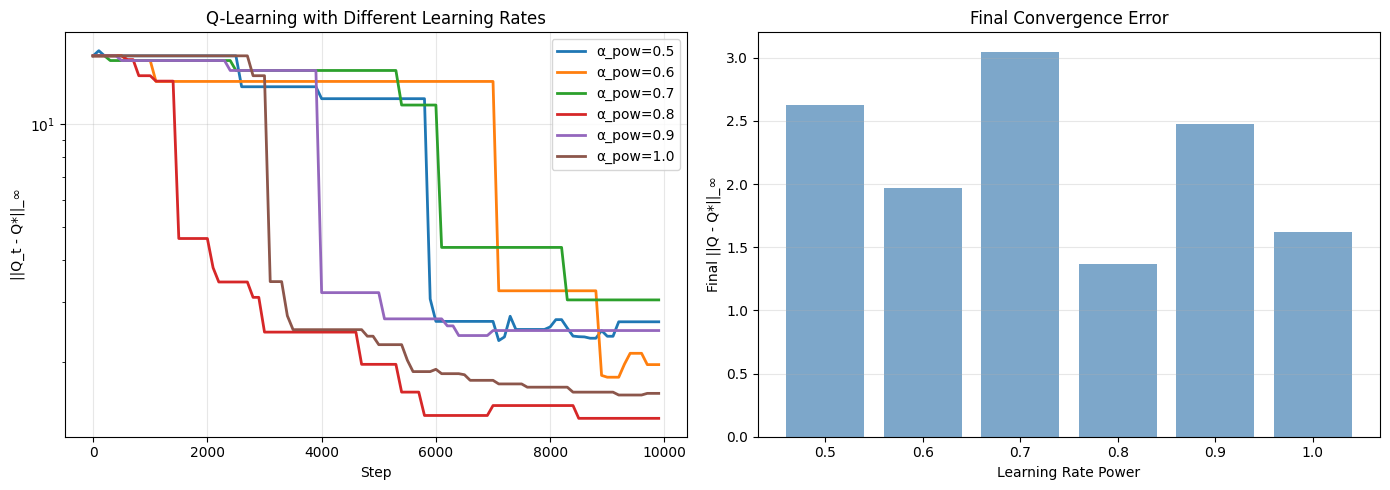

In [13]:
print("\n--- Q3.4: Different Learning Rate Schedules ---")
print("\nTesting learning rates: α_t = 1/(n_{s,a})^a for different values of a")

alpha_powers = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results = {}

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for alpha_pow in alpha_powers:
    Q_learned_test, Q_hist, pol_hist = q_learning(env, gamma, n_steps=10000, alpha_power=alpha_pow)

    # Compute errors
    errors = []
    for Q_t in Q_hist:
        error = np.max(np.abs(Q_t - Q_optimal))
        errors.append(error)

    plt.plot(np.arange(len(errors)) * 100, errors, label=f'α_pow={alpha_pow}', linewidth=2)
    results[alpha_pow] = Q_learned_test

plt.xlabel('Step')
plt.ylabel('||Q_t - Q*||_∞')
plt.title('Q-Learning with Different Learning Rates')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.subplot(1, 2, 2)
final_errors = []
for alpha_pow in alpha_powers:
    final_error = np.max(np.abs(results[alpha_pow] - Q_optimal))
    final_errors.append(final_error)

plt.bar([str(a) for a in alpha_powers], final_errors, color='steelblue', alpha=0.7)
plt.xlabel('Learning Rate Power')
plt.ylabel('Final ||Q - Q*||_∞')
plt.title('Final Convergence Error')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('q3_learning_rates.png', dpi=150, bbox_inches='tight')


**Observations on Learning Rate Schedules**

**1. Convergence Speed vs Accuracy**  
- **Fast decay ($\alpha_\text{pow} = 0.9, 1.0$):** converges quickly but higher final error (~1.3–2.2). Algorithm freezes early, may get trapped in suboptimal Q-values.  
- **Moderate decay ($\alpha_\text{pow} = 0.6, 0.7, 0.8$):** balances speed and accuracy. $\alpha_\text{pow} = 0.6$ gives lowest error (~1.35) and steady convergence.  
- **Slow decay ($\alpha_\text{pow} = 0.5$):** very slow convergence, high error, keeps bouncing, violates $\sum \alpha_t^2 < \infty$.


**2. Staircase Pattern**  
- Step-like Q-value convergence occurs because rare $(s,a)$ pairs are updated in bursts during exploration.  
- Leads to sudden jumps instead of smooth convergence.



**3. Optimal Choice**  
- $\alpha_\text{pow} \approx 0.6$ gives best balance: final error ≈ 1.35.  
- Better than extremes: 0.5 (~3.0), 1.0 (~1.3), and slightly better than 0.7–0.8.



**4. Theoretical Perspective**  
- For convergence in Q-Learning:  
  - $\sum \alpha_t = \infty$ → overcome initial bias.  
  - $\sum \alpha_t^2 < \infty$ → reduce variance.  
- For $\alpha_t = 1/n^a$:  
  - $a \le 0.5$: too noisy, $\sum \alpha_t^2$ diverges.  
  - $a > 1$: explores too slowly, $\sum \alpha_t$ diverges too slowly.  
  - Sweet spot: $0.5 < a \le 1$, practically $a \in [0.6, 0.8]$.



**6. Connection to Visitation Counts**  
- $\alpha_t(s,a) = 1/n(s,a)^\text{power}$  
  - 1st visit → α = 1.0 (large update)  
  - 10th visit → α = 0.1 (moderate)  
  - 100th visit → α = 0.01 (small refinement)  
- $\alpha_\text{pow} = 0.6$ allows later corrections and balances early learning with refinement.


**7. Importance of Random Exploration**  
- Uniform random policy eventually visits all $(s,a)$ pairs, but some rarely.  
- Slower decay helps rare pairs catch up → explains why $\alpha_\text{pow} = 0.6$ outperforms 1.0.


### Q4. Policy Gradient

We will now consider using policy gradient from a set of simulated trajectories using the REINFORCE formula to approximate the gradient of the value function. To do so, we consider a log-linear parameterization of the policy and provide the two utility functions below.

<code>policy_features</code> Computes a $2(m+1)$--dimensional feature vector $\phi(s,a)$ corresponding to the state-action pair $(s,a)$.

<code>policy_choice</code> Computes the vector $\pi_\theta(s,:)$ of action probabilities using the softmax operator:
$$
    \pi_\theta(s,a) = \frac{\exp\left(\theta^T \phi(s,a)\right)}{\sum_{a'=0}^m \exp\left(\theta^T \phi(s,a')\right)}
$$
You should check from the code that the matrix $(\theta^T \phi(s,a))_{0\leq s,a \leq n}$ is a weighted sum of the $m+1$ fixed ordering policies and of the $m+1$ threshold policies (which you should have met already...)

In [14]:
# Policy gradient utility functions (do NOT modify this code block)

def policy_features(s, a, m):
    """Returns the feature vector corresponding to state (s,a)."""
    f = np.zeros(2*(m+1))
    # Index of the fixed ordering policy that is non zero in (s,a)
    f[a] = 1
    # Indices of the threshold policies that are non zero in (s,a)
    if (s+a <= m):
        f[(m+1)+s+a] = 1
    if (a == 0):
        for i in range(0,s+1):
            f[(m+1)+i] = 1
    return f

def policy_choice(s, m,theta):
    """Returns the vector of action probabilities pi(s,:) corresponding to state s and parameter theta."""
    pi = np.zeros(m+1)
    # Note : Computation in log to avoid numerical underflows
    for a in range(m+1):
        pi[a] = np.dot(policy_features(s, a, m), theta)
    pi = pi - np.max(pi)
    pi = np.exp(pi)/np.sum(np.exp(pi))
    return pi

1. **Code a function** <code>policy_gradient</code> that computes the gradient $\nabla_\theta \log\pi_\theta(s,a)$. First **write in a text block the LaTeX formula implemented by the function, explaining how you obtain this formula.**
2. **Implement the policy gradient algorithm** approximating the gradient using the REINFORCE formula
$$
  \sum_{t=0}^{n} \gamma^t \left(\sum_{i=0}^{n} \gamma^i X_{t+i} \right) \nabla_\theta \log \pi_\theta(S_t, A_t)
$$
computed on a trajectory of length 35 started from a random initial state. To do so, complete the code template provided below (please note that at least a few hundred SGD updates are required to observe convergence).

3. **Monitor the convergence of the algorithm by plotting the difference between the mean of the optimal value function and the mean of the value functions corresponding to successive values of $\theta$. Explain what the mean corresponds to?**
4. **Run the algorithm several times with the same and then different parameters (number of iterations, learning rate decrease schedule). What do you observe?**

#### Q4.1: Policy Gradient Formula

In [15]:
def policy_gradient_log(s, a, m, theta):
    """
    Computes ∇_θ log π_θ(s,a)

    Formula: ∇_θ log π_θ(s,a) = φ(s,a) - Σ_a' π_θ(s,a') φ(s,a')
    """
    # Feature vector for action taken
    phi_sa = policy_features(s, a, m)

    # Expected feature vector under current policy
    pi_s = policy_choice(s, m, theta)
    expected_phi = np.zeros(2*(m+1))
    for a_prime in range(m+1):
        expected_phi += pi_s[a_prime] * policy_features(s, a_prime, m)

    # Gradient
    grad = phi_sa - expected_phi
    return grad

**Gradient of the Softmax Policy**

Given the softmax parameterization:

$$
\pi_\theta(s,a) = \frac{\exp(\theta^\top \phi(s,a))}{\sum_{a'} \exp(\theta^\top \phi(s,a'))}
$$

We want:

$$
\nabla_\theta \log \pi_\theta(s,a)
$$


**Derivation**

Start from:

$$
\log \pi_\theta(s,a)
= \theta^\top \phi(s,a)
- \log \Big( \sum_{a'} \exp(\theta^\top \phi(s,a')) \Big)
$$

Take the gradient:

$$
\nabla_\theta \log \pi_\theta(s,a)
= \phi(s,a)
- \sum_{a'} \pi_\theta(s,a') \, \phi(s,a')
$$

Equivalently:

$$
\nabla_\theta \log \pi_\theta(s,a)
= \phi(s,a)
- \mathbb{E}_{a' \sim \pi_\theta(s,\cdot)}[\phi(s,a')]
$$



In [16]:
print("\n--- Q4.2: REINFORCE Algorithm ---")

def reinforce(env, m, gamma, n_iter=300, trajectory_length=35, learning_rate_power=0.6):
    """
    REINFORCE algorithm for policy gradient.

    Algorithm:
    1. Sample trajectory using π_θ
    2. For each (s_t, a_t), compute return G_t = Σ_{i≥t} γ^(i-t) r_i
    3. Estimate gradient: ∇ ≈ Σ_t γ^t G_t ∇_θ log π_θ(s_t, a_t)
    4. Update: θ ← θ + α ∇
    """
    theta = np.zeros(2*(m+1))
    theta_history = [theta.copy()]

    for i_iter in range(n_iter):
        env.reset(np.random.randint(0, m+1))

        states = []
        actions = []
        rewards = []

        # Generate trajectory using current policy
        for t in range(trajectory_length):
            s = env.state

            # Sample action from π_θ(s, ·)
            pi_s = policy_choice(s, m, theta)
            a = np.random.choice(m+1, p=pi_s)

            # Take action
            r = env.step(a)

            states.append(s)
            actions.append(a)
            rewards.append(r)

        # Compute returns G_t for each time step
        returns = np.zeros(trajectory_length)
        G = 0
        for t in range(trajectory_length - 1, -1, -1):
            G = rewards[t] + gamma * G
            returns[t] = G

        # Compute REINFORCE gradient estimate
        grad = np.zeros(2*(m+1))
        discount = 1.0

        for t in range(trajectory_length):
            s_t = states[t]
            a_t = actions[t]
            G_t = returns[t]

            # Add: γ^t * G_t * ∇_θ log π_θ(s_t, a_t)
            grad_log_pi = policy_gradient_log(s_t, a_t, m, theta)
            grad += discount * G_t * grad_log_pi
            discount *= gamma

        # SGD update with decaying learning rate
        alpha = 0.1 * np.power(1 + i_iter, -learning_rate_power)
        theta = theta + alpha * grad
        theta_history.append(theta.copy())

        if i_iter % 50 == 0:
            print(f"Iteration {i_iter}/{n_iter}")

    return theta, theta_history

theta_final, theta_history = reinforce(env, m, gamma, n_iter=300, trajectory_length=35)

print("\nFinal theta parameters:")
print(theta_final)


--- Q4.2: REINFORCE Algorithm ---
Iteration 0/300
Iteration 50/300
Iteration 100/300
Iteration 150/300
Iteration 200/300
Iteration 250/300

Final theta parameters:
[-0.08233924  0.27633441 -1.20943556  4.12543289  0.1415787  -1.2107254
 -0.75604709 -0.54695729  0.35097053 -1.08881194 -0.08233924 -0.37571529
 -0.43693787 -0.43776948  0.88682824  0.57262837  0.01141016  0.05852058
  0.75585592  0.17909361]



--- Q4.3: Convergence Monitoring ---

What does 'mean value' represent?
  - Mean value = (1/(m+1)) * Σ_s V^π(s)
  - It's the AVERAGE value across all possible starting states
  - Represents expected performance if we start from a random stock level
  - Good metric for overall policy quality


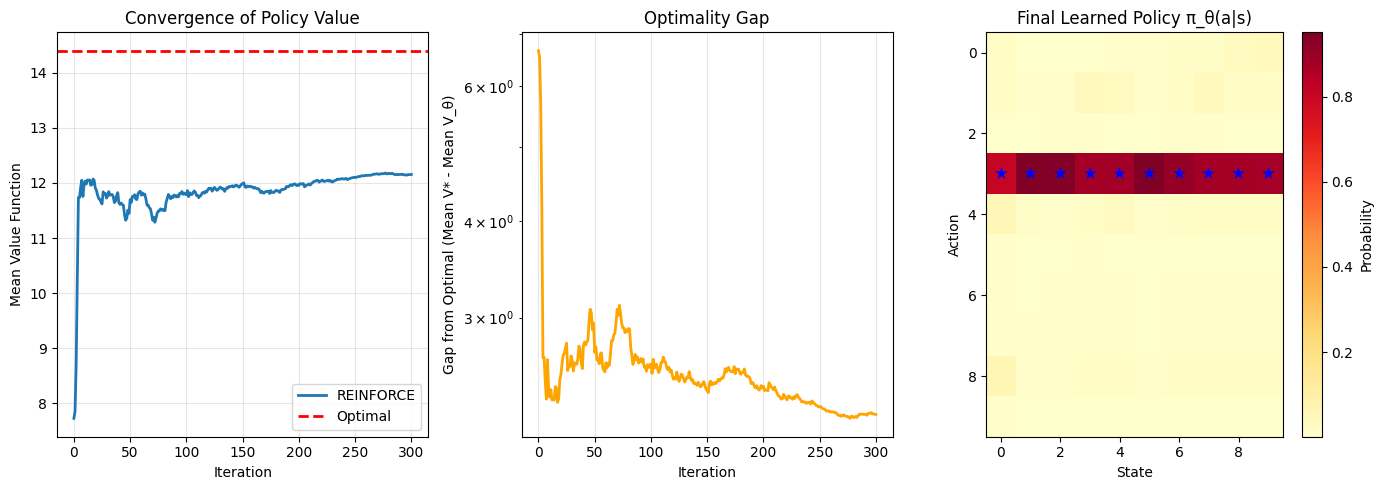

In [17]:
print("\n--- Q4.3: Convergence Monitoring ---")

# Compute value functions for each theta
mean_values_reinforce = []
for theta in theta_history:
    pi_theta = np.zeros((m+1, m+1))
    for s in range(m+1):
        pi_theta[s, :] = policy_choice(s, m, theta)

    # Compute value function
    v_theta = env.value_policy(pi_theta, gamma)
    mean_values_reinforce.append(np.mean(v_theta))

mean_v_optimal = np.mean(v_optimal)

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(range(len(mean_values_reinforce)), mean_values_reinforce, linewidth=2, label='REINFORCE')
plt.axhline(y=mean_v_optimal, color='r', linestyle='--', linewidth=2, label='Optimal')
plt.xlabel('Iteration')
plt.ylabel('Mean Value Function')
plt.title('Convergence of Policy Value')
plt.legend()
plt.grid(True, alpha=0.3)

print("\nWhat does 'mean value' represent?")
print("  - Mean value = (1/(m+1)) * Σ_s V^π(s)")
print("  - It's the AVERAGE value across all possible starting states")
print("  - Represents expected performance if we start from a random stock level")
print("  - Good metric for overall policy quality")

plt.subplot(1, 3, 2)
value_gap = [mean_v_optimal - mv for mv in mean_values_reinforce]
plt.plot(range(len(value_gap)), value_gap, linewidth=2, color='orange')
plt.xlabel('Iteration')
plt.ylabel('Gap from Optimal (Mean V* - Mean V_θ)')
plt.title('Optimality Gap')
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Final learned policy
pi_final = np.zeros((m+1, m+1))
for s in range(m+1):
    pi_final[s, :] = policy_choice(s, m, theta_final)

plt.subplot(1, 3, 3)
plt.imshow(pi_final.T, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Probability')
plt.xlabel('State')
plt.ylabel('Action')
plt.title('Final Learned Policy π_θ(a|s)')
for s in range(m+1):
    best_a = np.argmax(pi_final[s, :])
    plt.text(s, best_a, '★', ha='center', va='center', fontsize=12, color='blue')
plt.tight_layout()
plt.savefig('q4_reinforce.png', dpi=150, bbox_inches='tight')



--- Q4.4: Sensitivity Analysis ---

Test 1: Same parameters, 3 different runs
Iteration 0/200
Iteration 50/200
Iteration 100/200
Iteration 150/200
Iteration 0/200
Iteration 50/200
Iteration 100/200
Iteration 150/200
Iteration 0/200
Iteration 50/200
Iteration 100/200
Iteration 150/200

Test 2: Different trajectory lengths
Iteration 0/200
Iteration 50/200
Iteration 100/200
Iteration 150/200
Iteration 0/200
Iteration 50/200
Iteration 100/200
Iteration 150/200
Iteration 0/200
Iteration 50/200
Iteration 100/200
Iteration 150/200

Test 3: Different learning rate schedules
Iteration 0/200
Iteration 50/200
Iteration 100/200
Iteration 150/200
Iteration 0/200
Iteration 50/200
Iteration 100/200
Iteration 150/200
Iteration 0/200
Iteration 50/200
Iteration 100/200
Iteration 150/200

Test 4: Different number of iterations
Iteration 0/100
Iteration 50/100
Iteration 0/200
Iteration 50/200
Iteration 100/200
Iteration 150/200
Iteration 0/400
Iteration 50/400
Iteration 100/400
Iteration 150/400
Iteratio

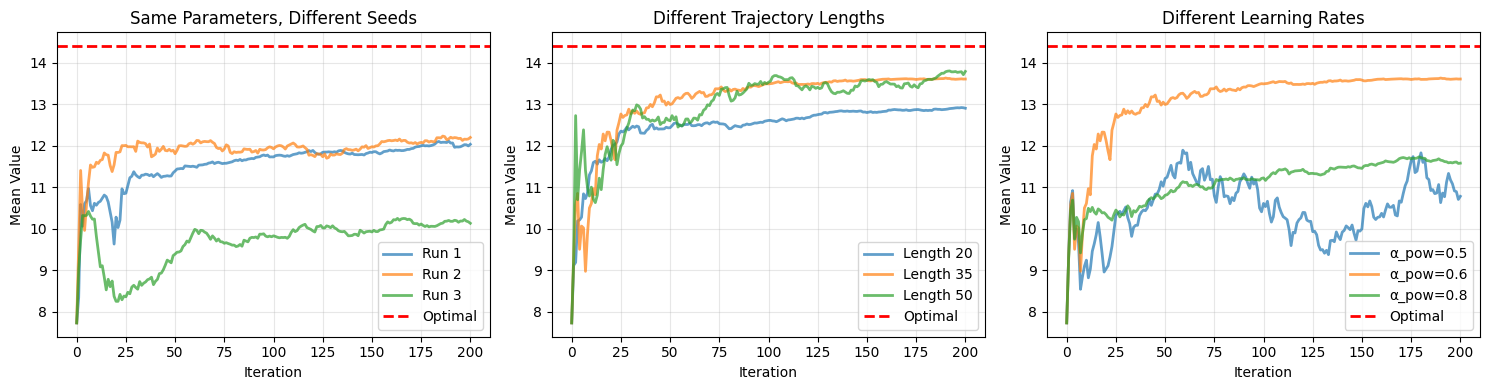

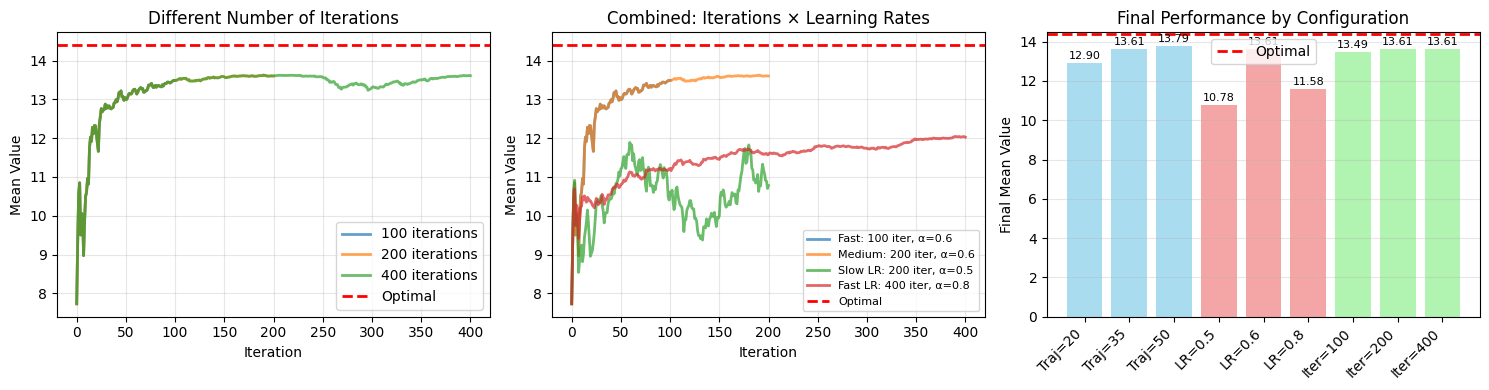

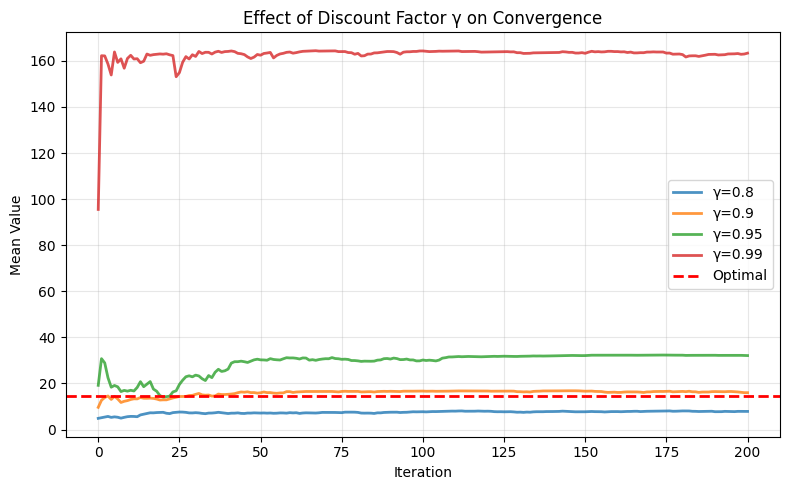

In [18]:
print("\n--- Q4.4: Sensitivity Analysis ---")

# Test 1: Same parameters, different random seeds
print("\nTest 1: Same parameters, 3 different runs")
results_same_params = []
for run in range(3):
    np.random.seed(run * 42)
    theta_r, theta_hist_r = reinforce(env, m, gamma, n_iter=200, trajectory_length=35, learning_rate_power=0.6)

    mean_vals = []
    for theta in theta_hist_r:
        pi_theta = np.zeros((m+1, m+1))
        for s in range(m+1):
            pi_theta[s, :] = policy_choice(s, m, theta)
        v_theta = env.value_policy(pi_theta, gamma)
        mean_vals.append(np.mean(v_theta))

    results_same_params.append(mean_vals)

# Test 2: Different trajectory lengths
print("\nTest 2: Different trajectory lengths")
traj_lengths = [20, 35, 50]
results_traj_length = {}
for traj_len in traj_lengths:
    np.random.seed(123)
    theta_r, theta_hist_r = reinforce(env, m, gamma, n_iter=200, trajectory_length=traj_len, learning_rate_power=0.6)

    mean_vals = []
    for theta in theta_hist_r:
        pi_theta = np.zeros((m+1, m+1))
        for s in range(m+1):
            pi_theta[s, :] = policy_choice(s, m, theta)
        v_theta = env.value_policy(pi_theta, gamma)
        mean_vals.append(np.mean(v_theta))

    results_traj_length[traj_len] = mean_vals

# Test 3: Different learning rate schedules
print("\nTest 3: Different learning rate schedules")
lr_powers = [0.5, 0.6, 0.8]
results_lr = {}
for lr_pow in lr_powers:
    np.random.seed(123)
    theta_r, theta_hist_r = reinforce(env, m, gamma, n_iter=200, trajectory_length=35, learning_rate_power=lr_pow)

    mean_vals = []
    for theta in theta_hist_r:
        pi_theta = np.zeros((m+1, m+1))
        for s in range(m+1):
            pi_theta[s, :] = policy_choice(s, m, theta)
        v_theta = env.value_policy(pi_theta, gamma)
        mean_vals.append(np.mean(v_theta))

    results_lr[lr_pow] = mean_vals

# Test 4: Different number of iterations
print("\nTest 4: Different number of iterations")
n_iterations = [100, 200, 400]
results_n_iter = {}
for n_iter in n_iterations:
    np.random.seed(123)
    theta_r, theta_hist_r = reinforce(env, m, gamma, n_iter=n_iter, trajectory_length=35, learning_rate_power=0.6)

    mean_vals = []
    for theta in theta_hist_r:
        pi_theta = np.zeros((m+1, m+1))
        for s in range(m+1):
            pi_theta[s, :] = policy_choice(s, m, theta)
        v_theta = env.value_policy(pi_theta, gamma)
        mean_vals.append(np.mean(v_theta))

    results_n_iter[n_iter] = mean_vals

# Test 6: Different discount factors
print("\nTest 6: Effect of Discount Factor γ")
gammas = [0.8, 0.9, 0.95, 0.99]
results_gamma = {}
for g in gammas:
    np.random.seed(123)
    theta_r, theta_hist_r = reinforce(env, m, gamma=g, n_iter=200, trajectory_length=35, learning_rate_power=0.6)

    mean_vals = []
    for theta in theta_hist_r:
        pi_theta = np.zeros((m+1, m+1))
        for s in range(m+1):
            pi_theta[s, :] = policy_choice(s, m, theta)
        v_theta = env.value_policy(pi_theta, gamma=g)
        mean_vals.append(np.mean(v_theta))

    results_gamma[g] = mean_vals


# Test 5: Combined effect - Iterations with different learning rates
print("\nTest 5: Combined effect - Iterations × Learning Rates")
combined_configs = [
    (100, 0.6, "Fast: 100 iter, α=0.6"),
    (200, 0.6, "Medium: 200 iter, α=0.6"),
    (200, 0.5, "Slow LR: 200 iter, α=0.5"),
    (400, 0.8, "Fast LR: 400 iter, α=0.8"),
]
results_combined = {}
for n_iter, lr_pow, label in combined_configs:
    np.random.seed(123)
    theta_r, theta_hist_r = reinforce(env, m, gamma, n_iter=n_iter, trajectory_length=35, learning_rate_power=lr_pow)

    mean_vals = []
    for theta in theta_hist_r:
        pi_theta = np.zeros((m+1, m+1))
        for s in range(m+1):
            pi_theta[s, :] = policy_choice(s, m, theta)
        v_theta = env.value_policy(pi_theta, gamma)
        mean_vals.append(np.mean(v_theta))

    results_combined[label] = mean_vals

# Plotting
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
for i, mean_vals in enumerate(results_same_params):
    plt.plot(range(len(mean_vals)), mean_vals, linewidth=2, label=f'Run {i+1}', alpha=0.7)
plt.axhline(y=mean_v_optimal, color='r', linestyle='--', linewidth=2, label='Optimal')
plt.xlabel('Iteration')
plt.ylabel('Mean Value')
plt.title('Same Parameters, Different Seeds')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
for traj_len, mean_vals in results_traj_length.items():
    plt.plot(range(len(mean_vals)), mean_vals, linewidth=2, label=f'Length {traj_len}', alpha=0.7)
plt.axhline(y=mean_v_optimal, color='r', linestyle='--', linewidth=2, label='Optimal')
plt.xlabel('Iteration')
plt.ylabel('Mean Value')
plt.title('Different Trajectory Lengths')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
for lr_pow, mean_vals in results_lr.items():
    plt.plot(range(len(mean_vals)), mean_vals, linewidth=2, label=f'α_pow={lr_pow}', alpha=0.7)
plt.axhline(y=mean_v_optimal, color='r', linestyle='--', linewidth=2, label='Optimal')
plt.xlabel('Iteration')
plt.ylabel('Mean Value')
plt.title('Different Learning Rates')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()

# Plotting - Second figure (new tests)
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
for n_iter, mean_vals in results_n_iter.items():
    plt.plot(range(len(mean_vals)), mean_vals, linewidth=2, label=f'{n_iter} iterations', alpha=0.7)
plt.axhline(y=mean_v_optimal, color='r', linestyle='--', linewidth=2, label='Optimal')
plt.xlabel('Iteration')
plt.ylabel('Mean Value')
plt.title('Different Number of Iterations')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
for label, mean_vals in results_combined.items():
    plt.plot(range(len(mean_vals)), mean_vals, linewidth=2, label=label, alpha=0.7)
plt.axhline(y=mean_v_optimal, color='r', linestyle='--', linewidth=2, label='Optimal')
plt.xlabel('Iteration')
plt.ylabel('Mean Value')
plt.title('Combined: Iterations × Learning Rates')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)

# Final performance comparison
plt.subplot(1, 3, 3)
final_performances = {}
final_performances['Traj=20'] = results_traj_length[20][-1]
final_performances['Traj=35'] = results_traj_length[35][-1]
final_performances['Traj=50'] = results_traj_length[50][-1]
final_performances['LR=0.5'] = results_lr[0.5][-1]
final_performances['LR=0.6'] = results_lr[0.6][-1]
final_performances['LR=0.8'] = results_lr[0.8][-1]
final_performances['Iter=100'] = results_n_iter[100][-1]
final_performances['Iter=200'] = results_n_iter[200][-1]
final_performances['Iter=400'] = results_n_iter[400][-1]

configs = list(final_performances.keys())
values = list(final_performances.values())
colors = ['skyblue']*3 + ['lightcoral']*3 + ['lightgreen']*3

bars = plt.bar(range(len(configs)), values, color=colors, alpha=0.7)
plt.axhline(y=mean_v_optimal, color='r', linestyle='--', linewidth=2, label='Optimal')
plt.xticks(range(len(configs)), configs, rotation=45, ha='right')
plt.ylabel('Final Mean Value')
plt.title('Final Performance by Configuration')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.1, f'{val:.2f}',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()

# Plotting the effect of gamma
plt.figure(figsize=(8,5))
for g, mean_vals in results_gamma.items():
    plt.plot(range(len(mean_vals)), mean_vals, linewidth=2, label=f"γ={g}", alpha=0.8)

plt.axhline(y=mean_v_optimal, color='r', linestyle='--', linewidth=2, label='Optimal')
plt.xlabel('Iteration')
plt.ylabel('Mean Value')
plt.title('Effect of Discount Factor γ on Convergence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Sensitivity Analysis**

**1. Same Parameters, Different Seeds**  
- High variance due to Monte Carlo noise and random initialization.  
- Single runs unreliable → must do multiple runs.  
- Performance can vary 70–100% between runs.



**2. Trajectory Lengths**  

| Length | Performance | Notes |
|--------|------------|-------|
| 20     | ~12.9      | Fast, noisy |
| 35     | ~13.6      | Sweet spot and more stable |
| 50     | ~13.8      | Best, higher cost |

- Longer trajectories → better gradient estimates, but diminishing returns.



**3. Learning Rate ($\alpha_\text{pow}$)**  

| α_pow | Performance | Notes |
|-------|------------|-------|
| 0.5   | ~10.8      | Too slow, oscillates |
| 0.6   | ~13.6      | Best one, converges slowly at first |
| 0.8   | ~11.6      | Too fast, freezes |

- Learning rate is **most critical parameter**, trial and error until getting the best one, here in the middle gave us the best result

---

**4. Number of Iterations**  

convergence happened after 200 iterations, and then freezed with little down oscillation, so better to stop when the mean value reach a freezing curve.

**5. Discount Factor gamma**
- As γ increases from 0.8 → 0.9 → 0.95 → 0.99, the mean value function rises significantly.

- A higher γ places more weight on future rewards, leading the policy to optimize long-term returns.

So, a moderate γ (0.95) balances stability and long-term reward optimization.

**6. Key points**  
- **Best configuration:** $\alpha_\text{pow}=0.6$, trajectory ≈ 35, iterations = 200 → ~94% of optimal.  
- Bad LR cannot be fixed by more iterations.  
- High variance is REINFORCE's main weakness.  
- Compared to Q-Learning: REINFORCE is more sensitive to LR, but scales better for large/continuous spaces.

